# Analyis of ERPs

## Optiones

In [2]:
bids_root_path_100 = "/media/marc/Medien/xmasoddballmatch-bids"
pipeline_name_100 = "pipeline01"        
    
bids_root_path_150 = "/media/marc/Medien/machristine-bids"
pipeline_name_150 = "pipeline_christine"

In [3]:
%matplotlib inline

## Loading Dependencies and Defining Functions
Load MNE and read configuration file.

In [4]:
from preprocessing.configuration import load_configuration

import analysis.utils as utils

from os.path import join
import mne
from mne_bids import make_bids_basename, read_raw_bids
from mne_bids.utils import get_entity_vals

import preprocessing.plotting

import seaborn as sns

config = load_configuration("configuration/pipeline01_100.yml")


In [5]:
def difference_wave(evokeds_as_dict, conditions, grandaverage=False):
    out = [mne.combine_evoked([a, b], [1,-1]) for a, b in zip(
        evokeds_as_dict[conditions[0]], evokeds_as_dict[conditions[1]])]
    if grandaverage:
        return mne.grand_average(out)
    else:
        return out

## Read averaged ERPs from disk

Read averaged ERPs for each participant:

In [6]:
%%capture
ids_100 = get_entity_vals(join(bids_root_path_100, "derivatives"), "sub") 
ave_filenames_100 = [utils.get_derivative_file_name(
        bids_root_path_100, id, pipeline_name_100, ".fif", suffix="ave") for id in ids_100]
all_evokeds_100 = [mne.read_evokeds(ave_filename) for ave_filename in ave_filenames_100]

ids_150 = get_entity_vals(join(bids_root_path_150, "derivatives"), "sub") 
ave_filenames_150 = [utils.get_derivative_file_name(
        bids_root_path_150, id, pipeline_name_150, ".fif", suffix="ave") for id in ids_150]
all_evokeds_150 = [mne.read_evokeds(ave_filename) for ave_filename in ave_filenames_150]

Turn list of dicts of ERPs into dict of lists of ERPs:

In [7]:
evokeds_list_as_dict_100 = {key: [] for key in config["conditions_of_interest"]}

for evokeds_list in all_evokeds_100:
    for evoked in evokeds_list:
        try:
            evokeds_list_as_dict_100[evoked.comment].append(evoked)
        except KeyError:
            pass
            print("Missing condition in list.")

evokeds_list_as_dict_150 = {key: [] for key in config["conditions_of_interest"]}

for evokeds_list in all_evokeds_150:
    for evoked in evokeds_list:
        try:
            evokeds_list_as_dict_150[evoked.comment].append(evoked)
        except KeyError:
            pass
            print("Missing condition in list.")

## Find Preak Latency and Window
Following Sussmann (2005), peak laency is defined as the latency where the differnce wave between deviant and standard tones in the random condition reaches its maximum (within the `Fz` channel).

In [8]:
# Find peak and find a window (±25ms) 
diff = difference_wave(evokeds_list_as_dict_150, ("random/deviant", "random/standard"), grandaverage=True)
peak_latency = diff.pick(picks="FZ").get_peak(tmin = .1, tmax = .2,  return_amplitude = True)[1]

peakwindow = (peak_latency-0.025, peak_latency+0.025)

print("Peak Latency is {} s.".format(peak_latency))

Identifying common channels ...
Peak Latency is 0.1328125 s.


## Difference Waves (nopattern)

In [9]:
diff_waves = {str(n):mne.combine_evoked([eb, ea], weights=[1, -1]) for ea, eb, n in zip(evokeds_list_as_dict["random/nopattern/standard"], evokeds_list_as_dict["random/nopattern/deviant"], range(20))}
mne.viz.plot_compare_evokeds(diff_waves, picks="FZ", ci=False, colors=["black"]*25, legend=False)

NameError: name 'evokeds_list_as_dict' is not defined

## Visualize different Standards
Standards differ depending on their position in repsect to the preceeding deviant. Let's compare standards in the `random` condition:

In [ ]:
mne.viz.plot_compare_evokeds(   {"sta1":evokeds_list_as_dict["random/1/standard"],
                                 "sta2":evokeds_list_as_dict["random/2/standard"],
                                 "sta3":evokeds_list_as_dict["random/3/standard"],
                                 "sta4":evokeds_list_as_dict["random/4/standard"],
                                 "sta5":evokeds_list_as_dict["random/5/standard"]}, picks="FZ", ci=False, cmap="summer", title="Random")

Now we do the same for standardars in the `predicatble` condition:

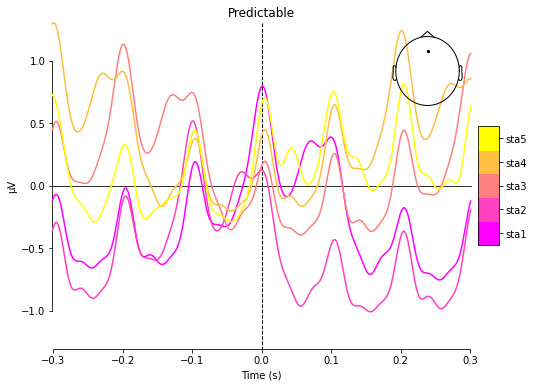

[<Figure size 576x432 with 3 Axes>]

In [9]:
mne.viz.plot_compare_evokeds(   {"sta1":evokeds_list_as_dict["predictable/1/standard"],
                                 "sta2":evokeds_list_as_dict["predictable/2/standard"],
                                 "sta3":evokeds_list_as_dict["predictable/3/standard"],
                                 "sta4":evokeds_list_as_dict["predictable/4/standard"],
                                 "sta5":evokeds_list_as_dict["predictable/5/standard"]}, picks="FZ", ci=False, cmap="spring", title="Predictable")

In [10]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import ptitprince as pt
import pandas as pd
import matplotlib.gridspec as gridspec
import scipy as sp
from copy import deepcopy

plt.ioff()

In [29]:
def get_mean_amplitudes(evokeds, window, picks = "all"):

    means = []
    if isinstance(evokeds, list):
        for i, evoked in enumerate(evokeds):
            evoked = evoked.copy().pick(picks)

            _window = np.arange(evoked.time_as_index(window[0]),
                                evoked.time_as_index(window[1]))

            data = evoked.data[:, _window]
            mean = data.mean()
            means.append(mean)
    else:
        return get_mean_amplitudes([evokeds], window, picks)[0]

    return means


def plot_conditions(data, cond1, cond2, pick="FZ", 
                    p_val = .05, 
                    peak = .140, 
                    title=None, 
                    axs=None, 
                    rerefernce = None,  
                    topo_cmap="RdYlBu_r", 
                    palette = "Set2",
                    erp_lims = (-2,2),
                    mmn_lims = (-2, 2)):
    
    data = deepcopy(data)

    palette = matplotlib.cm.get_cmap(palette).colors
    
    if axs is None:
        fig = plt.figure(constrained_layout=False, figsize = (9,3));
        fig.suptitle(title)
        ax, ax2 = fig.subplots(ncols=2, sharey = True);
    else:
        ax = axs[0]
        ax2 = axs[1]
        ax3 = axs[2]
        ax4 = axs[3]
        
        N1_avg = np.int(np.round(np.mean([e.nave for e in data[cond1]])))
        N2_avg = np.int(np.round(np.mean([e.nave for e in data[cond2]])))
        
        ax.set_title(title.format(N1="($N_{{{{avg}}}} = {}$)".format(N1_avg), 
                                  N2="($N_{{{{avg}}}} = {}$)").format(N2_avg))


    if rerefernce is not None:
        data[cond1] = [mne.set_eeg_reference(ev.copy(), rerefernce)[0] for ev in data[cond1]]
        data[cond2] = [mne.set_eeg_reference(ev.copy(), rerefernce)[0] for ev in data[cond2]]
        
    # Calculate diff waves
    org_diff_waves = [mne.combine_evoked([e1,e2], [1,-1]) for e1,e2 in zip(data[cond1], data[cond2])]
        
    # Combine Channels
    data[cond1] = [mne.channels.combine_channels(ev.copy(), {"mean": mne.pick_channels(ev.info["ch_names"], pick)}) for ev in data[cond1]]
    data[cond2] = [mne.channels.combine_channels(ev.copy(), {"mean": mne.pick_channels(ev.info["ch_names"], pick)}) for ev in data[cond2]]
    
    # Calculate diff waves
    diff_waves = [mne.combine_evoked([e1,e2], [1,-1]) for e1,e2 in zip(data[cond1], data[cond2])]

    condition1 = np.vstack(np.squeeze([ev.copy().pick("mean").data for ev in data[cond1]])) * 10e5
    condition2 = np.vstack(np.squeeze([ev.copy().pick("mean").data for ev in data[cond2]])) * 10e5
    

    T_obs, p_values, H0 =  mne.stats.permutation_t_test(condition1 - condition2, tail=0)
    
    # Plot mean MMN amplitudes
    mean_amplitudes_all = get_mean_amplitudes(diff_waves, peakwindow, picks = ["mean"]) 
    
    pdata_o = pd.DataFrame({"id":range(len(mean_amplitudes_all)), "mean_amplitude": mean_amplitudes_all})
    pdata = pdata_o.melt(id_vars=['id'])
    pdata["value"] = pdata["value"]  * 10e5
    
    ax2.axhline(0, .1, .9, color="k");
    ax2 = pt.RainCloud(x="variable", y = "value", data = pdata, ax = ax2, bw = .4, width_viol=.3, palette=palette);



    #ax2.set_ylim(mmn_lims[0]-.5,mmn_lims[1]+.5)

    #ax2.spines['left'].set_bounds(*mmn_lims)

    #ax2.set_yticks(mmn_lims)
    #ax2.set_yticklabels([str(t) for t in mmn_lims], textstyle)

 

    # Plot ERPs   
    times = data[cond1][0].times
    
    ax.axhline(0, 0, 1, color="k");

    ax.plot(times, condition1.mean(axis=0)-condition2.mean(axis=0), color=palette[0], linewidth=3, label="difference");
    ax.plot(times, condition1.mean(axis=0), linestyle="dashed", color=palette[1], linewidth=2, label=cond1);
    ax.plot(times, condition2.mean(axis=0), linestyle="dashed", color=colors[2], linewidth=2, label=cond2);
    
    # Set Limits,Ticks and format Spines
    #ax.set_ylim(erp_lims[0]-.25, erp_lims[1]+.25)
    #axs2[0].set_yticks(erp_lims)
    #axs2[0].set_yticklabels(["-1.5", "1.5"], textstyle)
    #ax.spines['left'].set_bounds(*erp_lims)
    
    ttest = sp.stats.ttest_1samp(pdata_o["mean_amplitude"], 0)
    
    ax2.set_title("$p = {p:.4f}$".format(p=ttest[1]));
    ax2.set_ylabel("")
    
    ax.axvspan(peakwindow[0], peakwindow[1], color='k', alpha=0.1);

    ax.set_xlim(-.1,.3);
    
    last_p = 1
    span_start = 0
    
    ax.legend(loc="upper left", ncol=3);
    
    for i, p in enumerate(p_values):
        
        #print("i = ", i, "p =", p, "t = ", times[i])
        
        if last_p >= p_val and p > p_val:
            span_start = i
            
        if last_p < p_val and p >= p_val:
            #if i - span_start > 0
            ax.axvspan(times[span_start], times[i], facecolor='#fcd703', edgecolor="orange", alpha=0.2);
        
        last_p = p
    else:
        if last_p < p_val:
            ax.axvspan(times[span_start], times[i], facecolor='#fcd703', edgecolor="orange", alpha=0.2, label="p < .05");

    gavg = mne.grand_average(org_diff_waves)

    vmax = lambda data: max(data) - .01
    vmin = lambda data: min(data) + .01
    
    mne.viz.plot_evoked_topomap(gavg, peak, axes = axs[2:4], cmap=topo_cmap, average = 0.50, show=False, colorbar=True, vmin = vmin, vmax=vmax);
    axs[2].set_title("")
    #axs[1].get_xaxis().set_visible(False)

    return fig if axs is None else axs

Permuting 9999 times...
Identifying common channels ...
Permuting 9999 times...
Identifying common channels ...
Permuting 9999 times...
Identifying common channels ...
Permuting 9999 times...
Identifying common channels ...
Permuting 9999 times...
Identifying common channels ...
Permuting 9999 times...
Identifying common channels ...
Permuting 9999 times...
Identifying common channels ...
Permuting 9999 times...
Identifying common channels ...
Permuting 9999 times...
Identifying common channels ...
Permuting 9999 times...
Identifying common channels ...
Permuting 9999 times...
Identifying common channels ...
Permuting 9999 times...
Identifying common channels ...
Permuting 9999 times...
Identifying common channels ...
Permuting 9999 times...
Identifying common channels ...


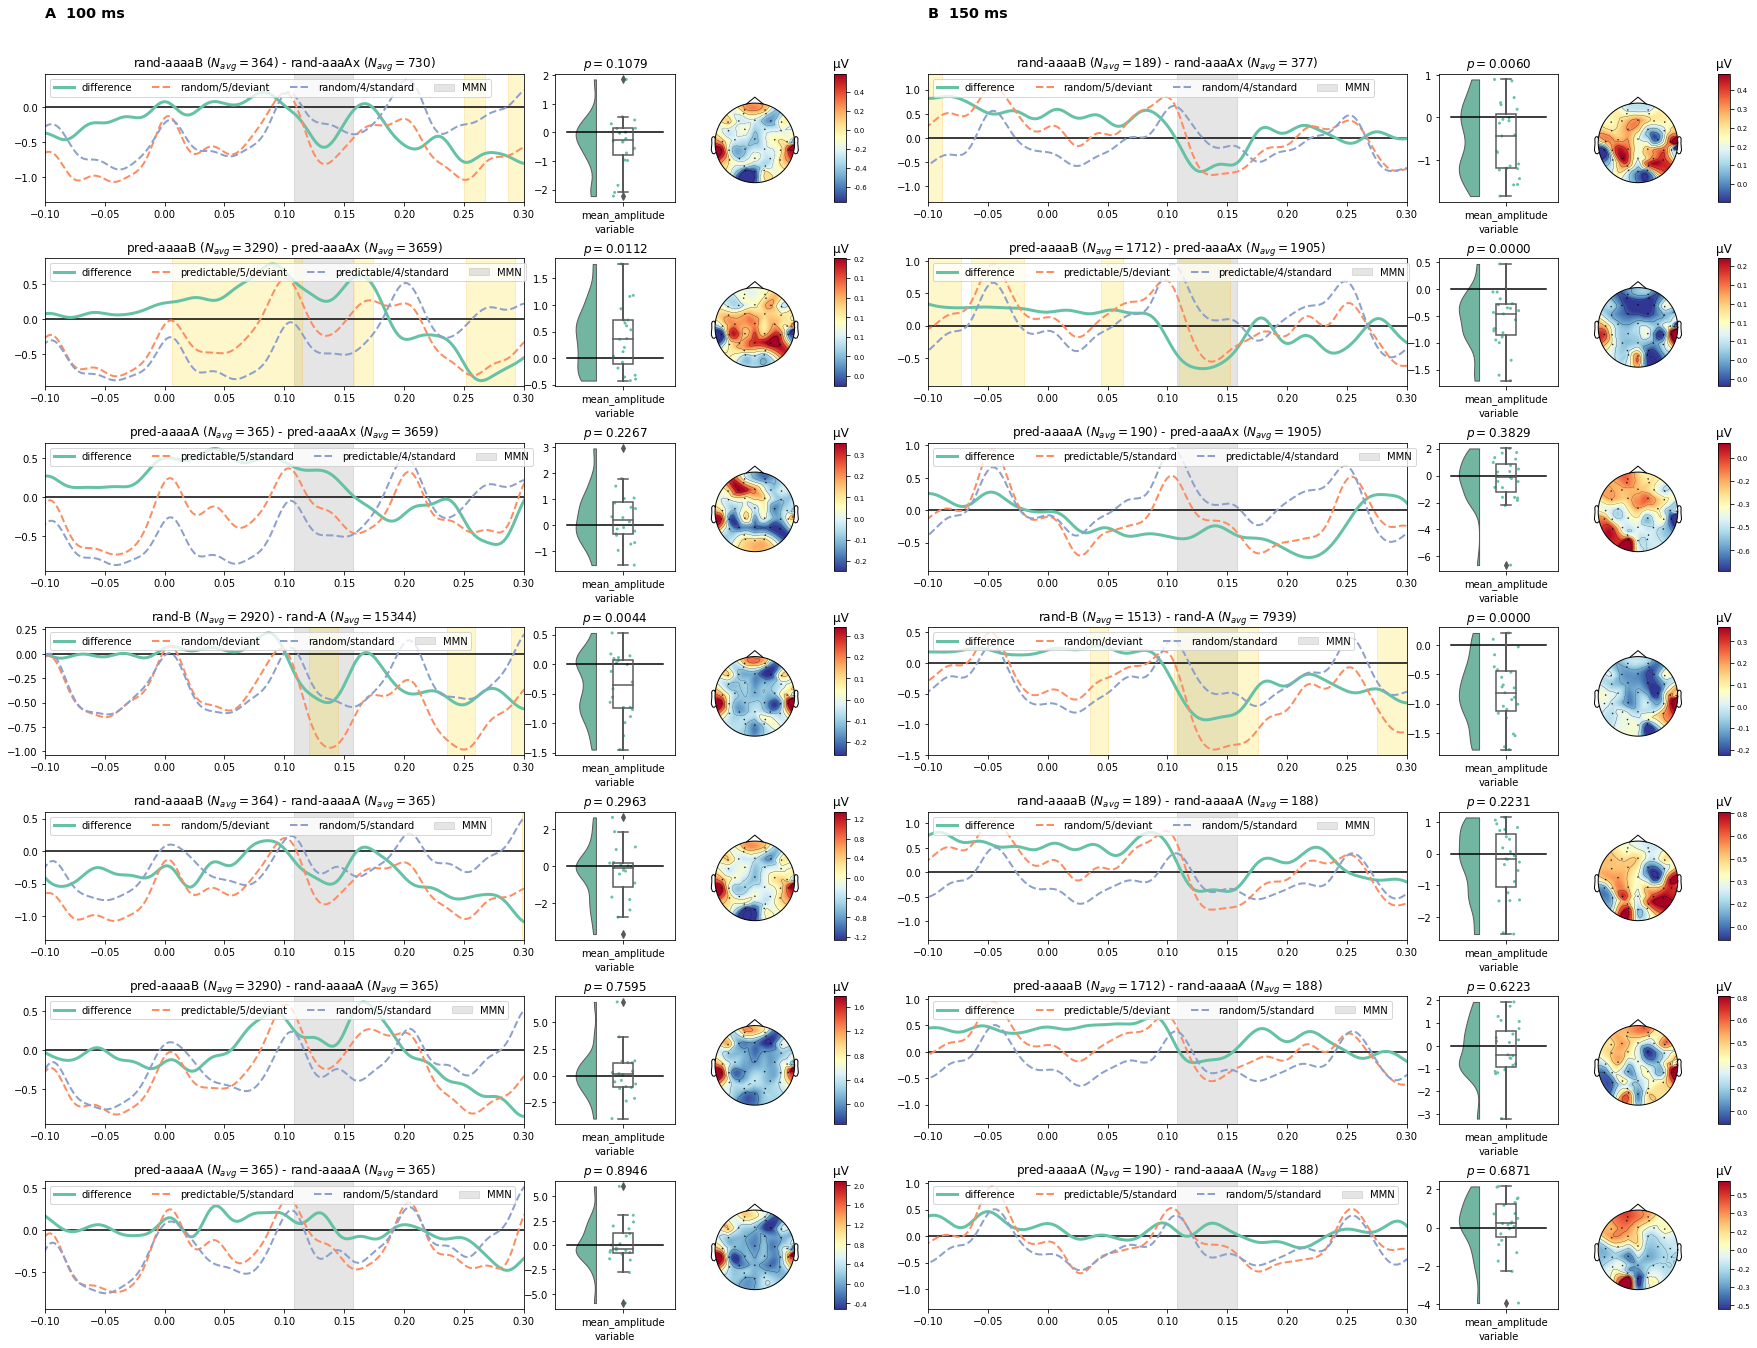

In [28]:
compare = { "rand-aaaaB {N1} - rand-aaaAx {N2}":("random/5/deviant", "random/4/standard"),
            "pred-aaaaB {N1} - pred-aaaAx {N2}":("predictable/5/deviant", "predictable/4/standard"),
            "pred-aaaaA {N1} - pred-aaaAx {N2}":("predictable/5/standard", "predictable/4/standard"),
            "rand-B {N1} - rand-A {N2}":("random/deviant", "random/standard"),
            #"pred-B {N1} vs. pred-A {N2}":("predictable/deviant", "predictable/standard"),
            "rand-aaaaB {N1} - rand-aaaaA {N2}":("random/5/deviant", "random/5/standard"),
            "pred-aaaaB {N1} - rand-aaaaA {N2}":("predictable/5/deviant", "random/5/standard"),
            "pred-aaaaA {N1} - rand-aaaaA {N2}":("predictable/5/standard", "random/5/standard")}


textstyle = {}

# Colors by C. Brewer
colors = ['#66c2a5','#fc8d62','#8da0cb']

fig = plt.figure(tight_layout=True, figsize = (26, 2.7* len(compare)), facecolor="white");
gs = gridspec.GridSpec(ncols=9, nrows=len(compare)+1, height_ratios=[.01]+len(compare)*[1], width_ratios=[4,1,.8,.1, .15, 4,1,.8,.1], figure=fig, hspace=.5)

pick=["FZ", "F3", "F4", "FC1", "FC2"]

for i, (l, c) in enumerate(compare.items(), 1):
    axs1 = (fig.add_subplot(gs[i, 0]), fig.add_subplot(gs[i, 1]), fig.add_subplot(gs[i, 2]), fig.add_subplot(gs[i, 3]))
    axs2 = (fig.add_subplot(gs[i, 5]), fig.add_subplot(gs[i, 6]), fig.add_subplot(gs[i, 7]), fig.add_subplot(gs[i, 8]))
    
    #axs[0].get_shared_y_axes().join(axs[0], axs[1])
    plot_conditions(evokeds_list_as_dict_100, c[0], c[1], title=l, axs=axs1, pick=pick, peak = peak_latency);
    plot_conditions(evokeds_list_as_dict_150, c[0], c[1], title=l, axs=axs2, pick=pick, peak = peak_latency);


text_style_heading = {"fontsize":"x-large", "fontweight":"bold"}

lhax = fig.add_subplot(gs[0, 0:4]);
lhax.axis('off');
lhax.text(0,0,"A  100 ms", **text_style_heading);

rhax = fig.add_subplot(gs[0, 5:8]);
rhax.axis('off');
rhax.text(0,0,"B  150 ms", **text_style_heading);

#fig.suptitle("ERPs for Channels {}".format(pick))
# plt.show(fig)
fig

Permuting 9999 times...
0.49108760897809134
Identifying common channels ...
Permuting 9999 times...
0.5785311824577933
Identifying common channels ...


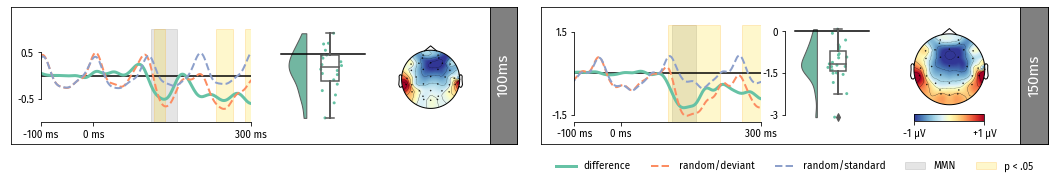

In [110]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

colors = ['#66c2a5','#fc8d62','#8da0cb']

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fpath = "../FiraSans-Regular.ttf"
prop = matplotlib.font_manager.FontProperties(fname=fpath)

textstyle = {"fontproperties": prop}



fig = plt.figure(tight_layout=True, figsize = (18, 3), facecolor="white");

dummy_axs = plt.figure().add_subplot()

gs = gridspec.GridSpec(ncols=4, nrows=2, width_ratios=[1,.06, 1,.06], height_ratios=[1,.2], figure=fig, hspace=.1, wspace=.1)

gs1 = gridspec.GridSpecFromSubplotSpec(ncols=4, nrows=3, height_ratios=[.15,1,.15], width_ratios=[.3, 6, 3, 2], subplot_spec=gs[0, 0])
axs1 = (fig.add_subplot(gs1[1, 1]), fig.add_subplot(gs1[1, 2]), fig.add_subplot(gs1[1, 3]), dummy_axs)


axs1[0].spines['left'].set_visible(True)
axs1[0].spines['left'].set_bounds(-.5, .5)
axs1[0].spines['top'].set_visible(False)
axs1[0].spines['right'].set_visible(False)
axs1[0].spines['bottom'].set_visible(True)


axs1[1].spines['left'].set_visible(False)
axs1[1].spines['top'].set_visible(False)
axs1[1].spines['right'].set_visible(False)
axs1[1].spines['bottom'].set_visible(False)

#axs1[0].get_shared_y_axes().join(axs1[0], axs1[1])
axs1[0].set_ylim(-1,1)
axs1[1].get_yaxis().set_visible(False)

axs1[0].set_xticks([-.1,0,.3])
axs1[0].set_xticklabels(["-100 ms", "0 ms", "300 ms"],  **textstyle)

axs1[0].set_yticks([-.5,.5])
axs1[0].set_yticklabels(["-0.5", "0.5"],  **textstyle)

frame1 = fig.add_subplot(gs[0, 0:2])
frame1.set_facecolor("None")
frame1.get_xaxis().set_visible(False)
frame1.get_yaxis().set_visible(False)
#frame1.set_title("Title A")


t1 = fig.add_subplot(gs[0, 1])
t1.set_facecolor("gray")
t1.get_xaxis().set_visible(False)
t1.get_yaxis().set_visible(False)

t1.text(.5, .5, "100ms", color="white", ha="center", va="center", fontsize=15, rotation = 90, transform=t1.transAxes, fontweight='bold',  **textstyle)


###########################

gs2 = gridspec.GridSpecFromSubplotSpec(ncols=4, nrows=3, height_ratios=[.1,1,.15], width_ratios=[.3, 6, 3, 3], wspace=.25, subplot_spec=gs[0, 2])
gs22 = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=2, height_ratios=[1,.1], subplot_spec=gs2[1, 3])
axs2 = (fig.add_subplot(gs2[1, 1]), fig.add_subplot(gs2[1, 2]), fig.add_subplot(gs22[0, 0]), dummy_axs)

# Add colorbar
cb_wrapper = fig.add_subplot(gs22[1, 0])
cb_wrapper.axis(False)
cbar_ax = inset_axes(cb_wrapper, width="75%", height="85%", loc='center')


norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
cmap = matplotlib.cm.get_cmap('RdYlBu_r')
cb = matplotlib.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                norm=norm,
                                ticks = [-1,1],
                                orientation='horizontal')
cb.set_ticklabels(["-1 µV", "+1 µV"])

for l in cb.ax.xaxis.get_ticklabels():
    l.set_fontproperties(prop)
                        

axs2[0].spines['left'].set_visible(True)
axs2[0].spines['left'].set_bounds(-1.5, 1.5)

axs2[0].spines['top'].set_visible(False)
axs2[0].spines['right'].set_visible(False)
axs2[0].spines['bottom'].set_visible(True)

axs2[1].spines['left'].set_visible(True)
axs2[1].spines['left'].set_bounds(-3, 0)
axs2[1].spines['top'].set_visible(False)
axs2[1].spines['right'].set_visible(False)
axs2[1].spines['bottom'].set_visible(False)

axs2[1].set_yticks([-3,-1.5,0])
axs2[1].set_yticklabels(["-3", "", "0"], textstyle)

#axs2[0].get_shared_y_axes().join(axs2[0], axs2[1])
axs2[0].set_yticks([-1.5,1.5])
axs2[0].set_yticklabels(["-1.5", "1.5"], textstyle)
axs2[0].set_ylim(-1.75,1.75)

axs2[0].set_xticks([-.1,0,.3])
axs2[0].set_xticklabels(["-100 ms", "0 ms", "300 ms"], textstyle)

#axs2[1].get_yaxis().set_visible(False)

frame2 = fig.add_subplot(gs[0, 2:4])
frame2.set_facecolor("None")
frame2.get_xaxis().set_visible(False)
frame2.get_yaxis().set_visible(False)
#frame2.set_title("Title B")


t2 = fig.add_subplot(gs[0, 3])
t2.set_facecolor("gray")
t2.get_xaxis().set_visible(False)
t2.get_yaxis().set_visible(False)

t2.text(.5, .5, "150ms", color="white", ha="center", va="center", fontsize=15, rotation = 90, transform=t2.transAxes, fontweight='bold',  **textstyle)


plot_conditions(evokeds_list_as_dict_100, "random/deviant", "random/standard", title="", axs=axs1, pick=["FZ"], peak = 0.135);
plot_conditions(evokeds_list_as_dict_150, "random/deviant", "random/standard", title="", axs=axs2, pick=["FZ"], peak = 0.135);


lines, labels = fig.axes[0].get_legend_handles_labels()

legend_ax = fig.add_subplot(gs[1, 2:4])
    
legend_ax.legend(lines, labels, loc='center', ncol=5, frameon=False, prop=prop)
legend_ax.axis(False)

axs1[0].get_legend().remove()
axs2[0].get_legend().remove()


fig.savefig("/home/marc/ba-thesis/input/figures/fig2.pdf", bbox_inches='tight')
fig.savefig("/home/marc/ba-thesis/input/figures/fig2.png", bbox_inches='tight')

fig

In [116]:
import matplotlib.font_manager
print([f for f in matplotlib.font_manager.fontManager.ttflist if "Fira" in f.name])


AttributeError: 'FontProperties' object has no attribute 'name'

In [12]:
import importlib
importlib.reload(matplotlib)


Bad key pcolormesh.snap in file /media/marc/Medien/xmas-oddballmatch/env/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc, line 134 ('pcolormesh.snap : True  # Whether to snap the mesh to pixel boundaries. This')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key date.converter in file /media/marc/Medien/xmas-oddballmatch/env/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc, line 452 ('date.converter:                  auto')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key date.interval_multiples in file /media/marc/Medien/xmas-oddballmatch/env/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc, line 454 ('date.interval_multiples:         True')
You probably need to get an updated mat

<module 'matplotlib' from '/media/marc/Medien/xmas-oddballmatch/env/lib/python3.8/site-packages/matplotlib/__init__.py'>